# **Detection Of Stress** 


<a id='Library_and_data_loading'></a>
## **1. Library and data loading** ##

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score



#Naive bayes
from sklearn.naive_bayes import GaussianNB 

#Stacking
from sklearn.ensemble import StackingClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "./input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

#reading in CSV's from a file path
train_df = pd.read_csv('input/survey.csv')


#Pandas: whats the data row count?
print(train_df.shape)
    
#Pandas: whats the distribution of the data?
print(train_df.describe())
    
#Pandas: What types of data do i have?
print(train_df.info())


(1259, 27)
                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-n

<a id='Data_cleaning'></a>
## **2. Data cleaning** ##

In [2]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)


                           Total   Percent
comments                    1095  0.869738
state                        515  0.409055
work_interfere               264  0.209690
self_employed                 18  0.014297
seek_help                      0  0.000000
obs_consequence                0  0.000000
mental_vs_physical             0  0.000000
phys_health_interview          0  0.000000
mental_health_interview        0  0.000000
supervisor                     0  0.000000
coworkers                      0  0.000000
phys_health_consequence        0  0.000000
mental_health_consequence      0  0.000000
leave                          0  0.000000
anonymity                      0  0.000000
Timestamp                      0  0.000000
wellness_program               0  0.000000
Age                            0  0.000000
benefits                       0  0.000000
tech_company                   0  0.000000
remote_work                    0  0.000000
no_employees                   0  0.000000
treatment  

In [3]:
#dealing with missing data
#Let’s get rid of the variables "Timestamp",“comments”, “state” just to make our lives easier.
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

train_df.isnull().sum().max() #just checking that there's no missing data missing...
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


**Cleaning NaN**

In [4]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)   

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [5]:
#clean 'Gender'
#Slower case all columm's elements
gender = train_df['Gender'].str.lower()
#print(gender)

#Select unique elements
gender = train_df['Gender'].unique()

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of bullshit
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [6]:
#complete missing age with mean
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

# Fill with media() values < 18 and > 120
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

#Ranges of Age
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)



In [7]:
#There are only 0.014% of self employed so let's change NaN to NOT self_employed
#Replace "NaN" string from defaultString
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [8]:
#There are only 0.20% of self work_interfere so let's change NaN to "Don't know
#Replace "NaN" string from defaultString

train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


<a id='Encoding_data'></a>
## **3. Encoding data**

In [9]:
#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()



label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


### Testing there aren't any missing data

In [10]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                           Total  Percent
Age                            0      0.0
Gender                         0      0.0
obs_consequence                0      0.0
mental_vs_physical             0      0.0
phys_health_interview          0      0.0
mental_health_interview        0      0.0
supervisor                     0      0.0
coworkers                      0      0.0
phys_health_consequence        0      0.0
mental_health_consequence      0      0.0
leave                          0      0.0
anonymity                      0      0.0
seek_help                      0      0.0
wellness_program               0      0.0
care_options                   0      0.0
benefits                       0      0.0
tech_company                   0      0.0
remote_work                    0      0.0
no_employees                   0      0.0
work_interfere                 0      0.0
treatment                      0      0.0
family_history                 0      0.0
self_employed                  0  

Features Scaling
We're going to scale age, because is extremely different from the othere ones.

<a id='Covariance_Matrix'></a>
## **4. Correlation Matrix. Variability comparison between categories of variables** 

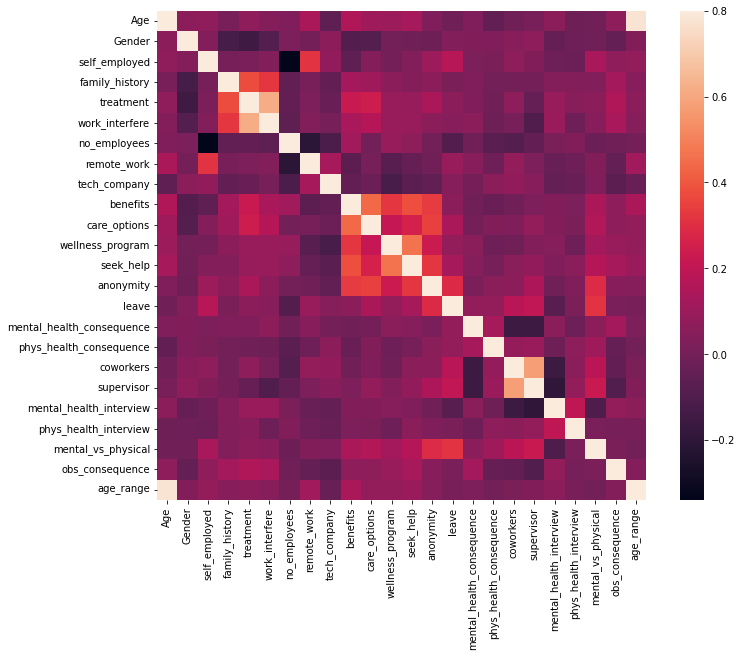

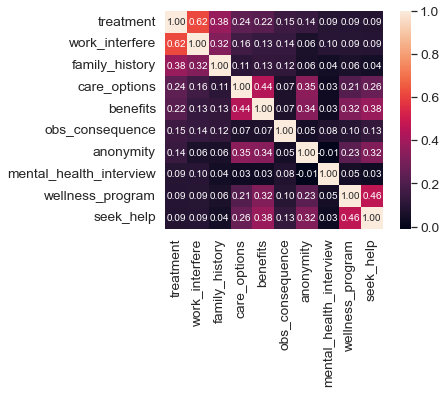

In [11]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()



<a id='Some_charts_to_see_data_relationship'></a>
## **5. Some Visualization to see data relationship**  

Distribiution and density by Age

In [12]:
# Processing age
train_df['Age'] = pd.to_numeric(train_df['Age'], errors='coerce')
def age_process(age):
    if age>=0 and age<=100:
        return age
    else:
        return np.nan

train_df['Age'] = train_df['Age'].apply(age_process)

In [13]:
(train_df['Age']<0).sum()

0

In [14]:
(train_df['Age']>100).sum()

0

In [15]:
(train_df['Age']<60).sum()

1257

In [16]:
train_df['Age'].isnull().sum()

0

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Age')

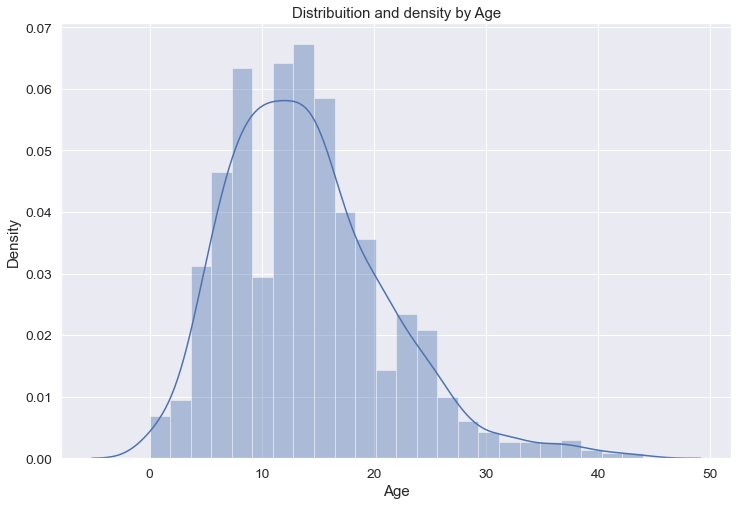

In [17]:
# Distribiution and density by Age
plt.figure(figsize=(12,8))
sns.distplot(train_df["Age"], bins=24)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")



In [18]:
# Age vs Family-History
train_df['Age_Group'] = pd.cut(train_df['Age'].dropna(),
                        [0, 18, 25, 35, 45, 99],
                        labels=['<18','18-24','25-34','35-44','45+'])

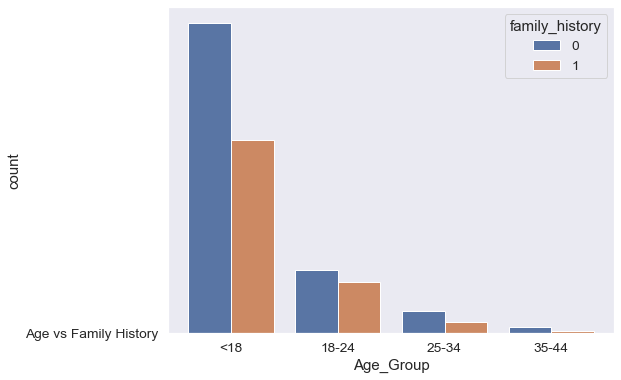

In [19]:
fig,ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=train_df, x = 'Age_Group', hue = 'family_history', ax = ax)
plt.plot('Age vs Family History')

Text(0.5, 1.0, 'Age Group vs Treatment')

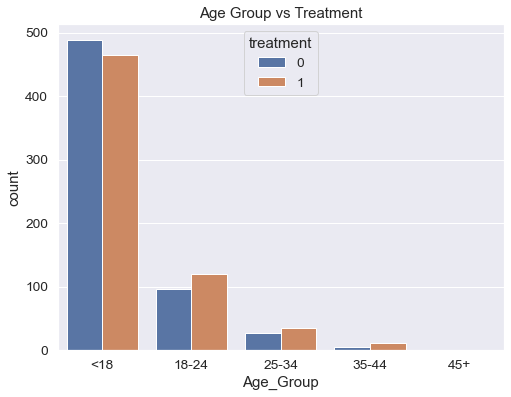

In [20]:
#Age group vs Treatment
fig,ax = plt.subplots(figsize=(8, 6))
sns.countplot(data = train_df, x = 'Age_Group', hue='treatment')
plt.title('Age Group vs Treatment')

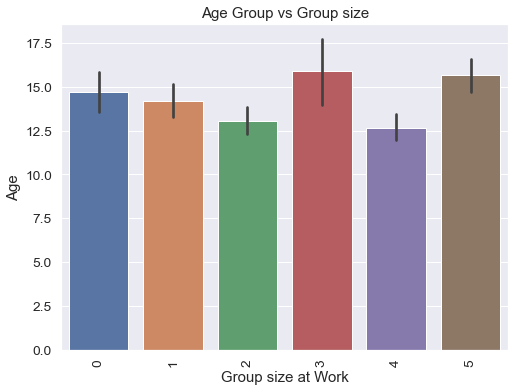

In [21]:
#Age vs No. of Employees
fig,ax = plt.subplots(figsize=(8, 6))
sns.barplot(data = train_df, x =  train_df['no_employees'], y = train_df['Age'], ax = ax)
plt.title('Age Group vs Group size')
plt.xlabel('Group size at Work')
plt.ylabel('Age')
ticks = plt.setp(ax.get_xticklabels(), rotation=90)

Text(0.5, 0, 'employee group')

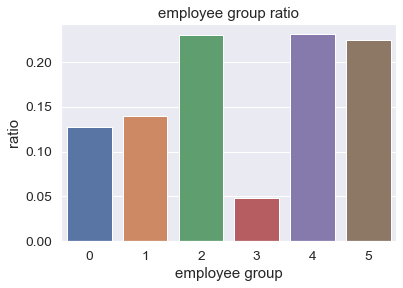

In [22]:
total = train_df['no_employees'].dropna().shape[0] * 1.0
employee_count  = Counter(train_df['no_employees'].dropna().tolist())
for key,val in employee_count.items():
    employee_count[key] = employee_count[key] / total
employee_group = np.asarray(list(employee_count.keys()))
employee_val = np.asarray(list(employee_count.values()))
sns.barplot(x = employee_group , y = employee_val)
plt.title('employee group ratio')
plt.ylabel('ratio')
plt.xlabel('employee group')

Text(0.5, 1.0, 'no_employee vs tech_company')

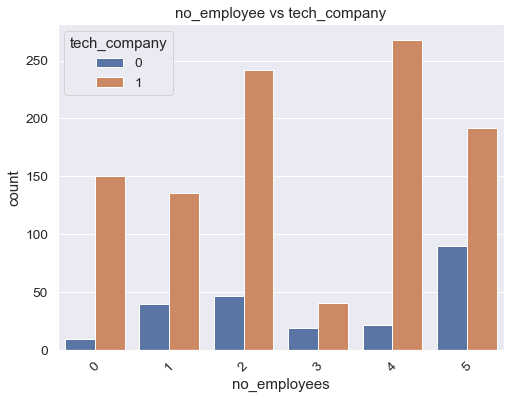

In [23]:
fig,ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=train_df, x='no_employees', hue='tech_company', ax=ax)
ticks = plt.setp(ax.get_xticklabels(),rotation=45)
plt.title('no_employee vs tech_company')

Text(0.5, 1.0, 'No. Employees vs Remote Work')

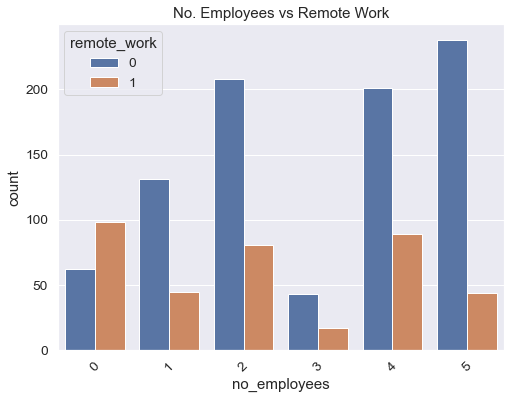

In [24]:
# Remote Work vs employee grp
fig,ax = plt.subplots(figsize=(8, 6))
sns.countplot(data = train_df, x = 'no_employees', hue = 'remote_work', ax=ax)
ticks = plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('No. Employees vs Remote Work')

Separate by treatment

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


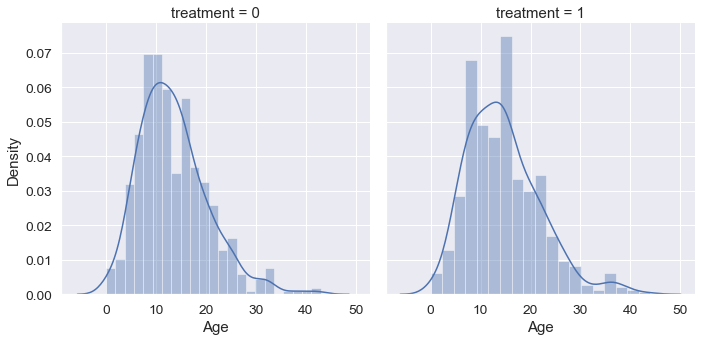

In [25]:
# Separate by treatment or not

g = sns.FacetGrid(train_df, col='treatment', size=5)
g = g.map(sns.distplot, "Age")

Draw a nested barplot to show probabilities for class and sex

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


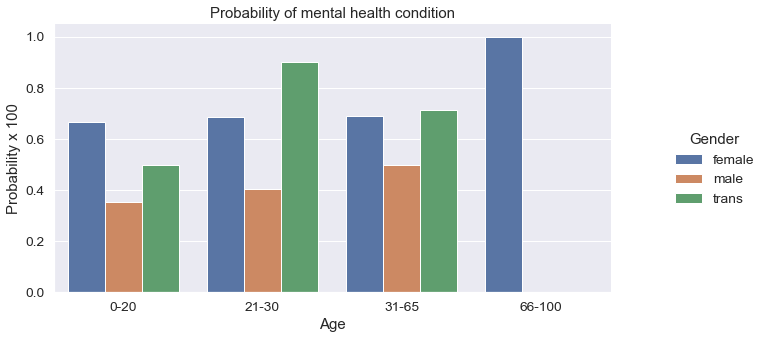

In [26]:
o = labelDict['label_age_range']

g = sns.factorplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar",  ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
# replace legend labels

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for family history

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


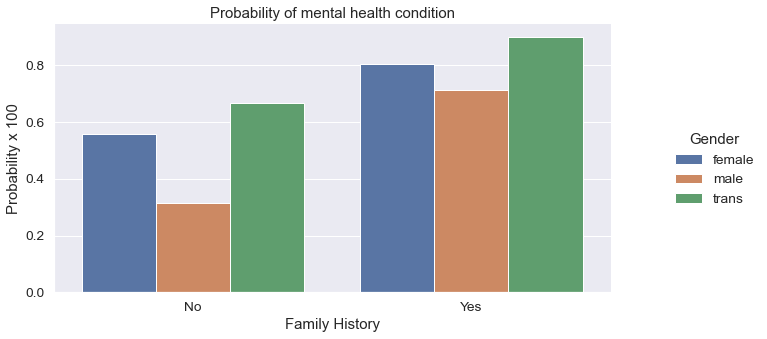

In [27]:
o = labelDict['label_family_history']
g = sns.factorplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for care options

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


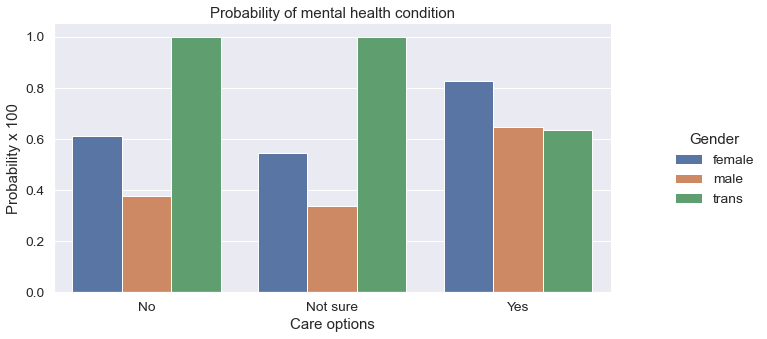

In [28]:
o = labelDict['label_care_options']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for benefits

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


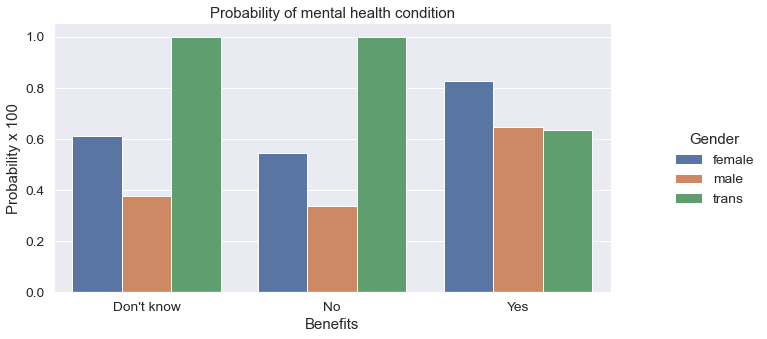

In [29]:
o = labelDict['label_benefits']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for work interfere

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


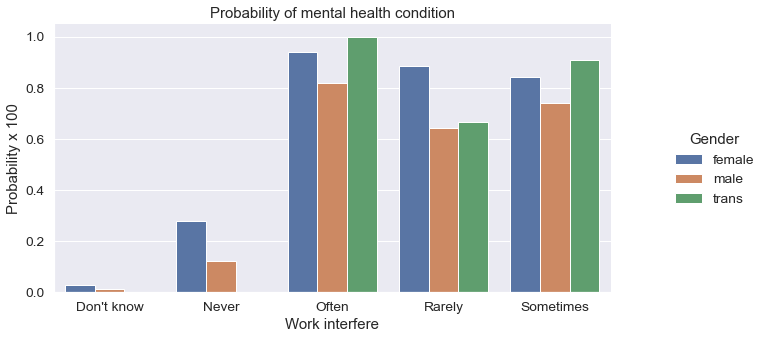

In [30]:
o = labelDict['label_work_interfere']
g = sns.factorplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Spliltting the dataset

In [31]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()



In [32]:
X

,Age,Gender,family_history,benefits,care_options,anonymity,leave,work_interfere
0,19,0,0,2,1,2,2,2
1,26,1,0,0,0,0,0,3
2,14,1,0,1,0,0,1,3
3,13,1,1,1,2,1,1,2
4,13,1,0,2,0,0,0,1
...,...,...,...,...,...,...,...,...
1254,8,1,0,1,0,0,2,0
1255,14,1,1,2,2,2,1,2
1256,16,1,1,2,2,0,1,4
1257,28,0,0,1,2,0,0,0


In [33]:
y

0       1
1       0
2       0
3       1
4       0
       ..
1254    1
1255    1
1256    1
1257    0
1258    1
Name: treatment, Length: 1257, dtype: int32

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train_fit, X_test_fit, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Support Vector Machine

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
SVM = SVC()
SVM.fit(X_train_fit, y_train)
predictions = SVM.predict(X_test_fit)
val1 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for SVM: ", val1, "\n")
print("*Confusion Matrix for SVM: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for SVM: ")
print(classification_report(y_test, predictions))

*Accuracy score for SVM:  80.15873015873017 

*Confusion Matrix for SVM: 
[[122  51]
 [ 24 181]]
*Classification Report for SVM: 
              precision    recall  f1-score   support

           0       0.84      0.71      0.76       173
           1       0.78      0.88      0.83       205

    accuracy                           0.80       378
   macro avg       0.81      0.79      0.80       378
weighted avg       0.81      0.80      0.80       378



In [37]:
y_pred_svm = SVM.predict(X_test_fit)

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_svm)
cm

array([[122,  51],
       [ 24, 181]], dtype=int64)

In [39]:
from sklearn.metrics import accuracy_score
svm_result = accuracy_score(y_test,y_pred_svm)
print("Accuracy :",svm_result)

Accuracy : 0.8015873015873016


In [40]:
recall_svm = cm[0][0]/(cm[0][0] + cm[0][1])
precision_svm = cm[0][0]/(cm[0][0]+cm[1][1])
recall_svm,precision_svm

(0.7052023121387283, 0.40264026402640263)

# Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train_fit, y_train)
predictions = RF.predict(X_test_fit)
val2 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for RF: ", val2, "\n")
print("*Confusion Matrix for RF: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for RF: ")
print(classification_report(y_test, predictions))

*Accuracy score for RF:  79.8941798941799 

*Confusion Matrix for RF: 
[[126  47]
 [ 29 176]]
*Classification Report for RF: 
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       173
           1       0.79      0.86      0.82       205

    accuracy                           0.80       378
   macro avg       0.80      0.79      0.80       378
weighted avg       0.80      0.80      0.80       378



In [42]:
y_pred_rf = RF.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_rf)
cm
rf_result = accuracy_score(y_test,y_pred_rf)
print("Accuracy :",rf_result)
recall_rf = cm[0][0]/(cm[0][0] + cm[0][1])
precision_rf = cm[0][0]/(cm[0][0]+cm[1][1])
recall_rf,precision_rf

Accuracy : 0.798941798941799


(0.7283236994219653, 0.41721854304635764)

# Decision Tree Classifier

In [43]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X_train_fit, y_train)
predictions = DT.predict(X_test_fit)
val3 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for DT: ", val3, "\n")
print("*Confusion Matrix for DT: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for DT: ")
print(classification_report(y_test, predictions))

*Accuracy score for DT:  72.22222222222221 

*Confusion Matrix for DT: 
[[128  45]
 [ 60 145]]
*Classification Report for DT: 
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       173
           1       0.76      0.71      0.73       205

    accuracy                           0.72       378
   macro avg       0.72      0.72      0.72       378
weighted avg       0.73      0.72      0.72       378



In [44]:
y_pred_dt = DT.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_dt)
cm
dt_result = accuracy_score(y_test,y_pred_dt)
print("Accuracy :",dt_result)
recall_dt = cm[0][0]/(cm[0][0] + cm[0][1])
precision_dt = cm[0][0]/(cm[0][0]+cm[1][1])
recall_dt,precision_dt

Accuracy : 0.7222222222222222


(0.7398843930635838, 0.46886446886446886)

# KNeighborsClassifier

In [45]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
KNN.fit(X_train_fit, y_train)
predictions = KNN.predict(X_test_fit)
val4 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for KNN: ", val4, "\n")
print("*Confusion Matrix for KNN: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for KNN: ")
print(classification_report(y_test, predictions))

*Accuracy score for KNN:  75.66137566137566 

*Confusion Matrix for KNN: 
[[127  46]
 [ 46 159]]
*Classification Report for KNN: 
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       173
           1       0.78      0.78      0.78       205

    accuracy                           0.76       378
   macro avg       0.75      0.75      0.75       378
weighted avg       0.76      0.76      0.76       378



In [46]:
y_pred_knn = KNN.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_knn)
cm
knn_result = accuracy_score(y_test,y_pred_knn)
print("Accuracy :",knn_result)
recall_knn = cm[0][0]/(cm[0][0] + cm[0][1])
precision_knn = cm[0][0]/(cm[0][0]+cm[1][1])
recall_knn,precision_knn

Accuracy : 0.7566137566137566


(0.7341040462427746, 0.44405594405594406)

# LogisticRegression

In [47]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train_fit, y_train)
predictions = LR.predict(X_test_fit)
val5 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for LR: ", val5, "\n")
print("*Confusion Matrix for LR: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for LR: ")
print(classification_report(y_test, predictions))

*Accuracy score for LR:  80.15873015873017 

*Confusion Matrix for LR: 
[[127  46]
 [ 29 176]]
*Classification Report for LR: 
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       173
           1       0.79      0.86      0.82       205

    accuracy                           0.80       378
   macro avg       0.80      0.80      0.80       378
weighted avg       0.80      0.80      0.80       378



In [48]:
y_pred_lr = LR.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_lr)
cm
lr_result = accuracy_score(y_test,y_pred_lr)
print("Accuracy :",lr_result)
recall_lr = cm[0][0]/(cm[0][0] + cm[0][1])
precision_lr = cm[0][0]/(cm[0][0]+cm[1][1])
recall_lr,precision_lr

Accuracy : 0.8015873015873016


(0.7341040462427746, 0.41914191419141916)

# Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train_fit, y_train)
predictions = GNB.predict(X_test_fit)
val6 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for GNB: ", val6, "\n")
print("*Confusion Matrix for GNB: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for GNB: ")
print(classification_report(y_test, predictions))

*Accuracy score for GNB:  80.42328042328042 

*Confusion Matrix for GNB: 
[[140  33]
 [ 41 164]]
*Classification Report for GNB: 
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       173
           1       0.83      0.80      0.82       205

    accuracy                           0.80       378
   macro avg       0.80      0.80      0.80       378
weighted avg       0.81      0.80      0.80       378



In [50]:
cm = confusion_matrix(y_test,predictions)
cm
nb_result = accuracy_score(y_test,predictions)
print("Accuracy :",nb_result)
recall_nb = cm[0][0]/(cm[0][0] + cm[0][1])
precision_nb = cm[0][0]/(cm[0][0]+cm[1][1])
recall_nb,precision_nb

Accuracy : 0.8042328042328042


(0.8092485549132948, 0.4605263157894737)

# SVM - Linear Kernel

In [51]:
linear = SVC(kernel='linear')
linear.fit(X_train_fit, y_train)
predictions = linear.predict(X_test_fit)
val7 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for linear SVM ", val7, "\n")
print("*Confusion Matrix for linear SVM: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for linear SVM: ")
print(classification_report(y_test, predictions))

*Accuracy score for linear SVM  80.42328042328042 

*Confusion Matrix for linear SVM: 
[[123  50]
 [ 24 181]]
*Classification Report for linear SVM: 
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       173
           1       0.78      0.88      0.83       205

    accuracy                           0.80       378
   macro avg       0.81      0.80      0.80       378
weighted avg       0.81      0.80      0.80       378



In [52]:
y_pred_linear = linear.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_linear)
cm
linear_result = accuracy_score(y_test,y_pred_linear)
print("Accuracy :",linear_result)
recall_linear = cm[0][0]/(cm[0][0] + cm[0][1])
precision_linear = cm[0][0]/(cm[0][0]+cm[1][1])
recall_linear,precision_linear

Accuracy : 0.8042328042328042


(0.7109826589595376, 0.40460526315789475)

# SVM Polynomial Kernel

In [53]:
poly = SVC(kernel='poly', degree=8)
poly.fit(X_train_fit, y_train)
predictions = poly.predict(X_test_fit)
val8 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for Polynomial SVM ", val8, "\n")
print("*Confusion Matrix for Polynomial SVM: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for Polynomial SVM: ")
print(classification_report(y_test, predictions))

*Accuracy score for Polynomial SVM  56.613756613756614 

*Confusion Matrix for Polynomial SVM: 
[[158  15]
 [149  56]]
*Classification Report for Polynomial SVM: 
              precision    recall  f1-score   support

           0       0.51      0.91      0.66       173
           1       0.79      0.27      0.41       205

    accuracy                           0.57       378
   macro avg       0.65      0.59      0.53       378
weighted avg       0.66      0.57      0.52       378



In [54]:
y_pred_poly = poly.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_poly)
cm
poly_result = accuracy_score(y_test,y_pred_poly)
print("Accuracy :",poly_result)
recall_poly = cm[0][0]/(cm[0][0] + cm[0][1])
precision_poly = cm[0][0]/(cm[0][0]+cm[1][1])
recall_poly,precision_poly

Accuracy : 0.5661375661375662


(0.9132947976878613, 0.7383177570093458)

# SVM Gaussian Kernel

In [55]:
Gaussian_Kernel = SVC(kernel='rbf')
Gaussian_Kernel.fit(X_train_fit, y_train)
predictions = Gaussian_Kernel.predict(X_test_fit)
val9 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for Gaussian_Kernel SVM ", val9, "\n")
print("*Confusion Matrix for Gaussian_Kernel SVM: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for Gaussian_Kernel SVM: ")
print(classification_report(y_test, predictions))

*Accuracy score for Gaussian_Kernel SVM  80.15873015873017 

*Confusion Matrix for Gaussian_Kernel SVM: 
[[122  51]
 [ 24 181]]
*Classification Report for Gaussian_Kernel SVM: 
              precision    recall  f1-score   support

           0       0.84      0.71      0.76       173
           1       0.78      0.88      0.83       205

    accuracy                           0.80       378
   macro avg       0.81      0.79      0.80       378
weighted avg       0.81      0.80      0.80       378



In [56]:
y_pred_Gaussian_Kernel = Gaussian_Kernel.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_Gaussian_Kernel)
cm
Gaussian_Kernel_result = accuracy_score(y_test,y_pred_Gaussian_Kernel)
print("Accuracy :",Gaussian_Kernel_result)
recall_Gaussian_Kernel = cm[0][0]/(cm[0][0] + cm[0][1])
precision_Gaussian_Kernel = cm[0][0]/(cm[0][0]+cm[1][1])
recall_Gaussian_Kernel,precision_Gaussian_Kernel

Accuracy : 0.8015873015873016


(0.7052023121387283, 0.40264026402640263)

# SVM Sigmoid Kernel

In [57]:
sig = SVC(kernel='sigmoid')
sig.fit(X_train_fit, y_train)
predictions = sig.predict(X_test_fit)
val10 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for SVM Sigmoid Kernel ", val10, "\n")
print("*Confusion Matrix for SVM Sigmoid Kernel: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for SVM Sigmoid Kernel: ")
print(classification_report(y_test, predictions))

*Accuracy score for SVM Sigmoid Kernel  57.14285714285714 

*Confusion Matrix for SVM Sigmoid Kernel: 
[[108  65]
 [ 97 108]]
*Classification Report for SVM Sigmoid Kernel: 
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       173
           1       0.62      0.53      0.57       205

    accuracy                           0.57       378
   macro avg       0.58      0.58      0.57       378
weighted avg       0.58      0.57      0.57       378



In [58]:
y_pred_sig = sig.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_sig)
cm
sig_result = accuracy_score(y_test,y_pred_sig)
print("Accuracy :",sig_result)
recall_sig = cm[0][0]/(cm[0][0] + cm[0][1])
precision_sig = cm[0][0]/(cm[0][0]+cm[1][1])
recall_sig,precision_sig

Accuracy : 0.5714285714285714


(0.6242774566473989, 0.5)

# Voting Classifier

In [59]:
from sklearn.ensemble import VotingClassifier 
from sklearn.tree import DecisionTreeClassifier 
estimator = [] 
estimator.append(('LR',  
                  LogisticRegression(solver ='lbfgs',  
                                     multi_class ='multinomial',  
                                     max_iter = 200))) 
estimator.append(('SVC', SVC(gamma ='auto', probability = True))) 
estimator.append(('DTC', DecisionTreeClassifier())) 
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train_fit, y_train)
predictions = vot_hard.predict(X_test_fit)
val11 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for Voting Classifier: ", val11, "\n")
print("*Confusion Matrix for Voting Classifier: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for Voting Classifier: ")
print(classification_report(y_test, predictions))

*Accuracy score for Voting Classifier:  80.15873015873017 

*Confusion Matrix for Voting Classifier: 
[[124  49]
 [ 26 179]]
*Classification Report for Voting Classifier: 
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       173
           1       0.79      0.87      0.83       205

    accuracy                           0.80       378
   macro avg       0.81      0.79      0.80       378
weighted avg       0.80      0.80      0.80       378



In [60]:
y_pred_vot_hard = vot_hard.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_vot_hard)
cm
vot_hard_result = accuracy_score(y_test,y_pred_vot_hard)
print("Accuracy :",vot_hard_result)
recall_vot_hard = cm[0][0]/(cm[0][0] + cm[0][1])
precision_vot_hard = cm[0][0]/(cm[0][0]+cm[1][1])
recall_vot_hard,precision_vot_hard

Accuracy : 0.8015873015873016


(0.7167630057803468, 0.40924092409240925)

# Stacking Classifier

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]
sc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [62]:
sc.fit(X_train_fit, y_train)
predictions = sc.predict(X_test_fit)
val12 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for Stacking Classifier ", val12, "\n")
print("*Confusion Matrix for Stacking Classifier ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for Stacking Classifier: ")
print(classification_report(y_test, predictions))

*Accuracy score for Stacking Classifier  80.68783068783068 

*Confusion Matrix for Stacking Classifier 
[[127  46]
 [ 27 178]]
*Classification Report for Stacking Classifier: 
              precision    recall  f1-score   support

           0       0.82      0.73      0.78       173
           1       0.79      0.87      0.83       205

    accuracy                           0.81       378
   macro avg       0.81      0.80      0.80       378
weighted avg       0.81      0.81      0.81       378



In [63]:
y_pred_sc = sc.predict(X_test_fit)
cm = confusion_matrix(y_test, y_pred_sc)
cm
sc_hard_result = accuracy_score(y_test,y_pred_sc)
print("Accuracy :",sc_hard_result)
recall_sc = cm[0][0]/(cm[0][0] + cm[0][1])
precision_sc = cm[0][0]/(cm[0][0]+cm[1][1])
recall_sc,precision_sc

Accuracy : 0.8068783068783069


(0.7341040462427746, 0.4163934426229508)

# Model Comparsion

In [64]:
score = [val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12]
#make variabel for save the result and to show it
classifier = ('Suport Vector Machine','Random Forest','Decision Tree','KNNeighbors','Logistic Regression','Naive Bayes Classifier','SVM - Linear Kernel','SVM Polynomial Kernel','SVM Gaussian Kernel','SVM Sigmoid Kernel','Voting Classifier','Stacking Classifier')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[80.15873015873017, 79.8941798941799, 72.22222222222221, 75.66137566137566, 80.15873015873017, 80.42328042328042, 80.42328042328042, 56.613756613756614, 80.15873015873017, 57.14285714285714, 80.15873015873017, 80.68783068783068]


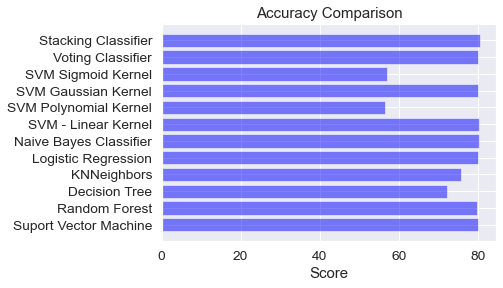

In [65]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Accuracy Comparison')
plt2.show()

# Pickle

In [66]:
X

,Age,Gender,family_history,benefits,care_options,anonymity,leave,work_interfere
0,19,0,0,2,1,2,2,2
1,26,1,0,0,0,0,0,3
2,14,1,0,1,0,0,1,3
3,13,1,1,1,2,1,1,2
4,13,1,0,2,0,0,0,1
...,...,...,...,...,...,...,...,...
1254,8,1,0,1,0,0,2,0
1255,14,1,1,2,2,2,1,2
1256,16,1,1,2,2,0,1,4
1257,28,0,0,1,2,0,0,0


In [67]:
import pickle
filename = 'model.pkl'
pickle.dump(GNB, open(filename, 'wb'))

In [68]:
s = np.array([19,0,0,2,1,2,2,2])
print(s.shape)
s = s.reshape(1,-1)
print(s.shape)

(8,)
(1, 8)


In [69]:
model = pickle.load(open('model.pkl', 'rb'))
print(model.predict(s))

[1]


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
